In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

from scipy.stats import trim_mean, bootstrap



In [17]:
def process_time_data_iqm(filepath, resample_rate=None, col="rewards/time", index=True, smooth=None):
    iqm = lambda scores: trim_mean(scores, proportiontocut=0.25).flatten()

    data = pd.read_csv(filepath)

    # remove duplicate columns 
    # mi = ~data.columns.str.endswith(f"__MIN")
    # ma = ~data.columns.str.endswith(f"__MAX")
    # data = data[data.columns[mi&ma]]

    # data = data.interpolate()
    if index:
        data.index = pd.to_timedelta(data["Relative Time (Process)"], unit="s")
    else:
        data.index = pd.to_timedelta(data["Relative Time (Process)"])
    data = data.drop("Relative Time (Process)", axis=1)
    # data = data.dropna()
    if resample_rate:
        data = data.resample(resample_rate).first().interpolate()

    data = data.drop(data.columns[data.columns.str.endswith(f"step")], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith(f"step__MIN")], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith(f"step__MAX")], axis=1)

    rnms = {}
    for st in data.columns:
        digits = ''.join(c for c in st if c.isdigit())
        add = ""
        add = "__MIN" if "MIN" in st else add
        add = "__MAX" if "MAX" in st else add
        rnms.update({st: f"N={digits}{add}"})

    data = data.rename(rnms, axis=1)

    # reset indexes for a fair comparison
    for col in data.columns:
        fi = data[col].first_valid_index()
        li = data[col].last_valid_index()
        nonna = data[col][fi:li].values
        data[col] = np.append(nonna, [np.nan]*(len(data)-len(nonna)))
            
    if smooth:
        for col in data.columns:
            data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
    return data

def process_fps(file, col="step_fps"):
    data = pd.read_csv(file)
    data = data.drop(data.columns[~data.columns.str.endswith(f"{col}")], axis=1)
    data = data.dropna()

    rnms = {}
    for st in data.columns:
        digits = ''.join(c for c in st if c.isdigit())
        rnms.update({st: digits})
    data = data.rename(rnms, axis=1)

    data = data.mean()
    data.index = data.index.astype(np.int64)
    return data

(50.0, 60.0)

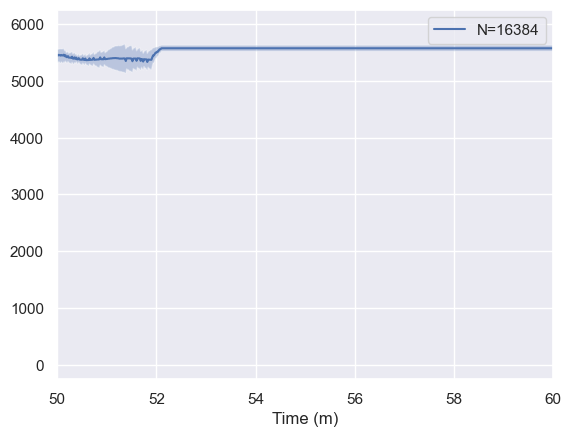

In [31]:
# data lab for exploration
data = process_time_data_iqm("data/ppo_reward.csv", smooth=0.9)
fps = process_fps("data/ppo_fps.csv")

i=0
for col in data.columns:
    if "MIN" not in col and "MAX" not in col:
        plt.plot(data.index.total_seconds()/60, data[col], label=col)
        plt.fill_between(data.index.total_seconds()/60, data[f"{col}__MIN"], data[f"{col}__MAX"], alpha=0.3)
        i += 1
        if i==1:
            break
plt.legend()
plt.xlabel("Time (m)")
plt.xlim((50,60))

In [32]:
lim = 4500
results = {}
for col in data.columns:
    if np.any(data[col] > lim):
        secs = data.index[data[col] > lim][0].total_seconds()
    else:
        secs = np.nan
    results.update({int(col.split("=")[-1].split("__")[0]): secs})

N = []
times = []
for key,value in sorted(results.items()):
    N.append(key)
    times.append(value)

results = pd.DataFrame(results.values(), results.keys())
results = results.sort_index()
results["rps"] = lim/results[0]
results["fps"] = fps
results

,0,rps,fps
64,1266.0,3.554502,17368.035039
128,624.0,7.211538,27903.042433
256,511.0,8.806262,33242.253549
512,339.0,13.274336,63403.050527
1024,293.0,15.358362,117627.154714
2048,167.0,26.946108,219887.875994
4096,203.0,22.167488,387293.941720
8192,186.0,24.193548,438188.087352
16384,358.0,12.569832,372448.586499


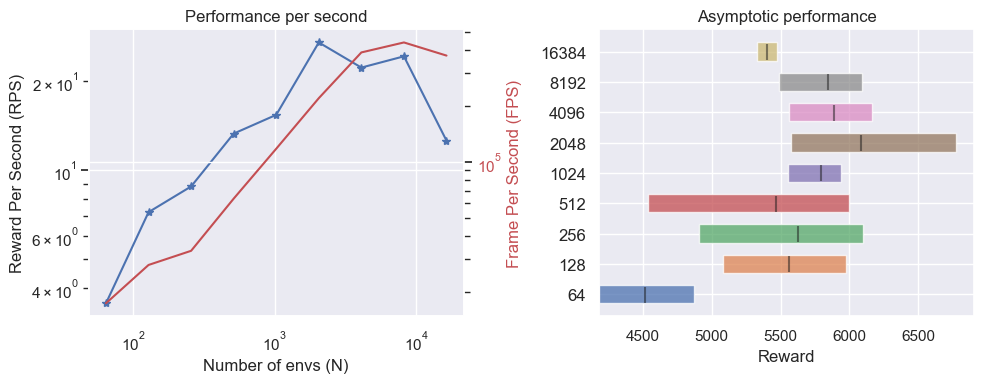

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

results.rps.plot(ax=ax1, style='-*', label="RPS")
ax1.set_ylabel("Reward Per Second (RPS)")
ax1.set_yscale("log")


ax11 = ax1.twinx()
results.fps.plot(ax=ax11, label="FPS", c='r')
ax11.tick_params(axis='y', labelcolor='r')
ax11.set_ylabel("Frame Per Second (FPS)", c='r')
ax11.set_yscale("log")

ax1.set_xscale("log")
ax1.set_xlabel("Number of envs (N)")
ax1.set_title("Performance per second")


# asymptotic performance
last = data.iloc[-1]
labels = results.index
h=0.6
for idx, alg in enumerate(labels):
    j = data[f"N={alg}"].argmax()
    if alg == 4096 or alg ==16384:
        j -= 100 # special handling for one off experiment
    ax2.barh(y=idx, width=data[f"N={alg}__MAX"][j] - data[f"N={alg}__MIN"][j], height=0.6, left=data[f"N={alg}__MIN"][j], alpha=0.75)
    ax2.vlines(x=data[f"N={alg}"][j],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
ax2.set_yticks(list(range(len(labels))))
ax2.set_yticklabels(labels, fontsize='medium')
ax2.set_xlabel("Reward")
ax2.set_title("Asymptotic performance")
plt.tight_layout()
plt.savefig("ppo_scaling.pdf")

# SHAC Baseline

Text(0.5, 0, 'Time (m)')

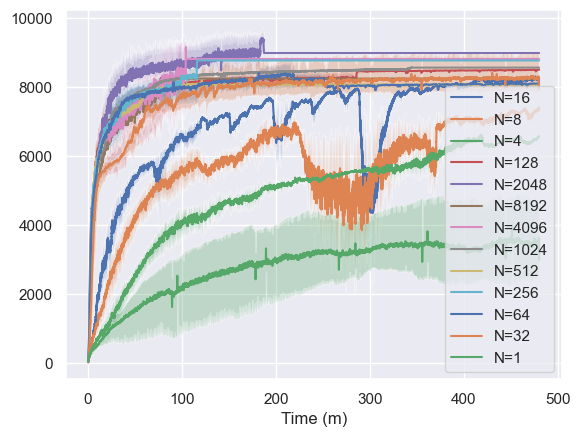

In [34]:
# data lab for exploration
data = process_time_data_iqm("data/shac_reward.csv", smooth=0.9)
fps = process_fps("data/shac_fps.csv", col="fps")

i=0
for col in data.columns:
    if "MIN" not in col and "MAX" not in col:
        plt.plot(data.index.total_seconds()/60, data[col], label=col)
        plt.fill_between(data.index.total_seconds()/60, data[f"{col}__MIN"], data[f"{col}__MAX"], alpha=0.3)
        i += 1
        # if i==2:
            # break
plt.legend()
plt.xlabel("Time (m)")


In [28]:
lim = 6000
results = {}
for col in data.columns:
    if np.any(data[col] > lim):
        secs = data.index[data[col] > lim][0].total_seconds()
    else:
        secs = np.nan
    results.update({int(col.split("=")[-1].split("__")[0]): secs})

N = []
times = []
for key,value in sorted(results.items()):
    N.append(key)
    times.append(value)

results = pd.DataFrame(results.values(), results.keys())
results = results.sort_index()
results["rps"] = lim/results[0]
results["fps"] = fps
results

,0,rps,fps
1,NaN,NaN,34.315377
4,19038.0,0.315159,56.276390
8,5882.0,1.020061,112.281090
16,4322.0,1.388246,222.895957
32,1821.0,3.294893,1141.809792
64,614.0,9.771987,2189.864526
128,408.0,14.705882,4227.644349
256,587.0,10.221465,6813.091909
512,496.0,12.096774,13187.631713
1024,569.0,10.544815,24507.587814


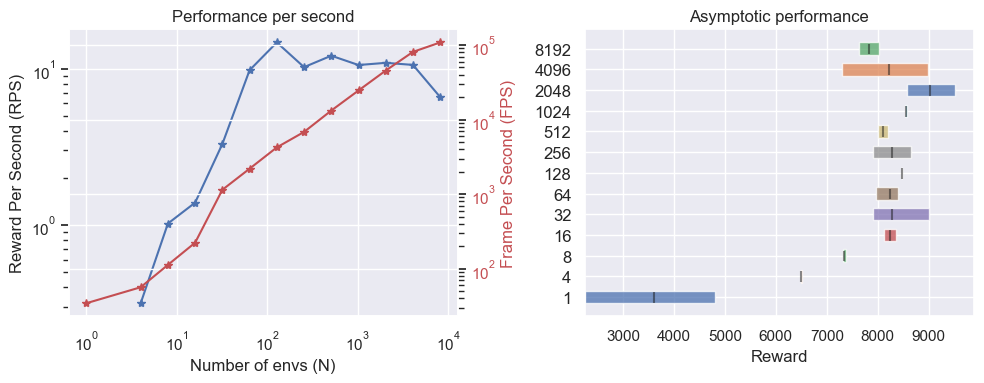

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

results.rps.plot(ax=ax1, style="-*", label="RPS")
ax1.set_ylabel("Reward Per Second (RPS)")
ax1.set_yscale("log")


ax11 = ax1.twinx()
results.fps.plot(ax=ax11, style="-*", label="FPS", c='r')
ax11.tick_params(axis='y', labelcolor='r')
ax11.set_ylabel("Frame Per Second (FPS)", c='r')
ax11.set_yscale("log")

ax1.set_xscale("log")
ax1.set_xlabel("Number of envs (N)")
ax1.set_title("Performance per second")


# asymptotic performance
last = data.iloc[-1]
labels = results.index
h=0.6
for idx, alg in enumerate(labels):
    j = data[f"N={alg}"].argmax()
    j -= 150
    # if alg == 4096 or alg ==16384:
    #     j -= 100 # special handling for one off experiment
    ax2.barh(y=idx, width=data[f"N={alg}__MAX"][j] - data[f"N={alg}__MIN"][j], height=0.6, left=data[f"N={alg}__MIN"][j], alpha=0.75)
    ax2.vlines(x=data[f"N={alg}"][j],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
ax2.set_yticks(list(range(len(labels))))
ax2.set_yticklabels(labels, fontsize='medium')
ax2.set_xlabel("Reward")
ax2.set_title("Asymptotic performance")
plt.tight_layout()
plt.savefig("shac_scaling.pdf")